<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Borrow Fees Alpha](Introduction.ipynb) › Part 3: Alphalens Analysis
***

# Alphalens Analysis

In this notebook, we use Alphalens to investigate whether borrow fees are a source of alpha. As Alphalens ignores transaction costs, note that we are not modeling borrow fees as a short selling cost in this notebook (that will be done in a later notebook). Instead, we are investigating whether borrow fee data are predictive of forward returns.

Start by setting the bundle for this notebook:

In [1]:
from zipline.research import use_bundle
use_bundle("usstock-1d-bundle")

Next, we create a Pipeline similar to the one in the previous notebook, but with the addition of a "size" column (using average dollar volume as a proxy for size), which will be used for subgroup analysis in the Alphalens tear sheet. In addition, we exclude microcap stocks from the analysis by limiting the screen to the top 75% by dollar volume. Microcap stocks exhibit different behavior from larger stocks and make the results murkier to interpret.

In [2]:
from zipline.pipeline import Pipeline, ibkr, master
from zipline.pipeline.factors import AverageDollarVolume

# limit analysis to common stocks
universe = master.SecuritiesMaster.usstock_SecurityType2.latest.eq("Common Stock")

borrow_fee = ibkr.BorrowFees.FeeRate.latest

avg_dollar_volume = AverageDollarVolume(window_length=90)

pipeline = Pipeline(
    columns={
        "borrow_fee": borrow_fee,
        "size": avg_dollar_volume.quantiles(4)
    },
    initial_universe=universe,
    screen=(
        # ignore microcaps
        avg_dollar_volume.percentile_between(26, 100)
        # Alphalens can't analyze Nulls, so exclude them
        & borrow_fee.notnull()
    )
)

Next, we run the Pipeline and generate the tear sheet. Note the `quantiles` parameter. As we saw in the previous notebook, most stocks cluster near the low end of the distribution, so instead of splitting the data into equal-sized quantiles, we partition the data at the 50th, 75th, and 90th percentiles, which should do a better job of splitting stocks into meaningful groups (low, medium, high, and very high borrow fees).

Commentary on the Alphalens output is provided after the tear sheet.

,min,max,mean,std,count,avg daily count,count %
Borrow Fee Quantile,,,,,,,
1,0.100,0.513,0.285,0.055,"2,618,688",1721.7,50.2%
2,0.262,2.503,0.598,0.288,"1,291,626",849.2,24.8%
3,0.452,23.967,3.465,3.243,"779,499",512.5,15.0%
4,2.109,"3,628.452",62.304,87.458,"521,617",342.9,10.0%


,1D
Ann. alpha,-0.304
beta,-0.043
Mean Return Top Quantile (bps),-9.390
Mean Return Bottom Quantile (bps),4.753
Mean Spread (bps),-14.143


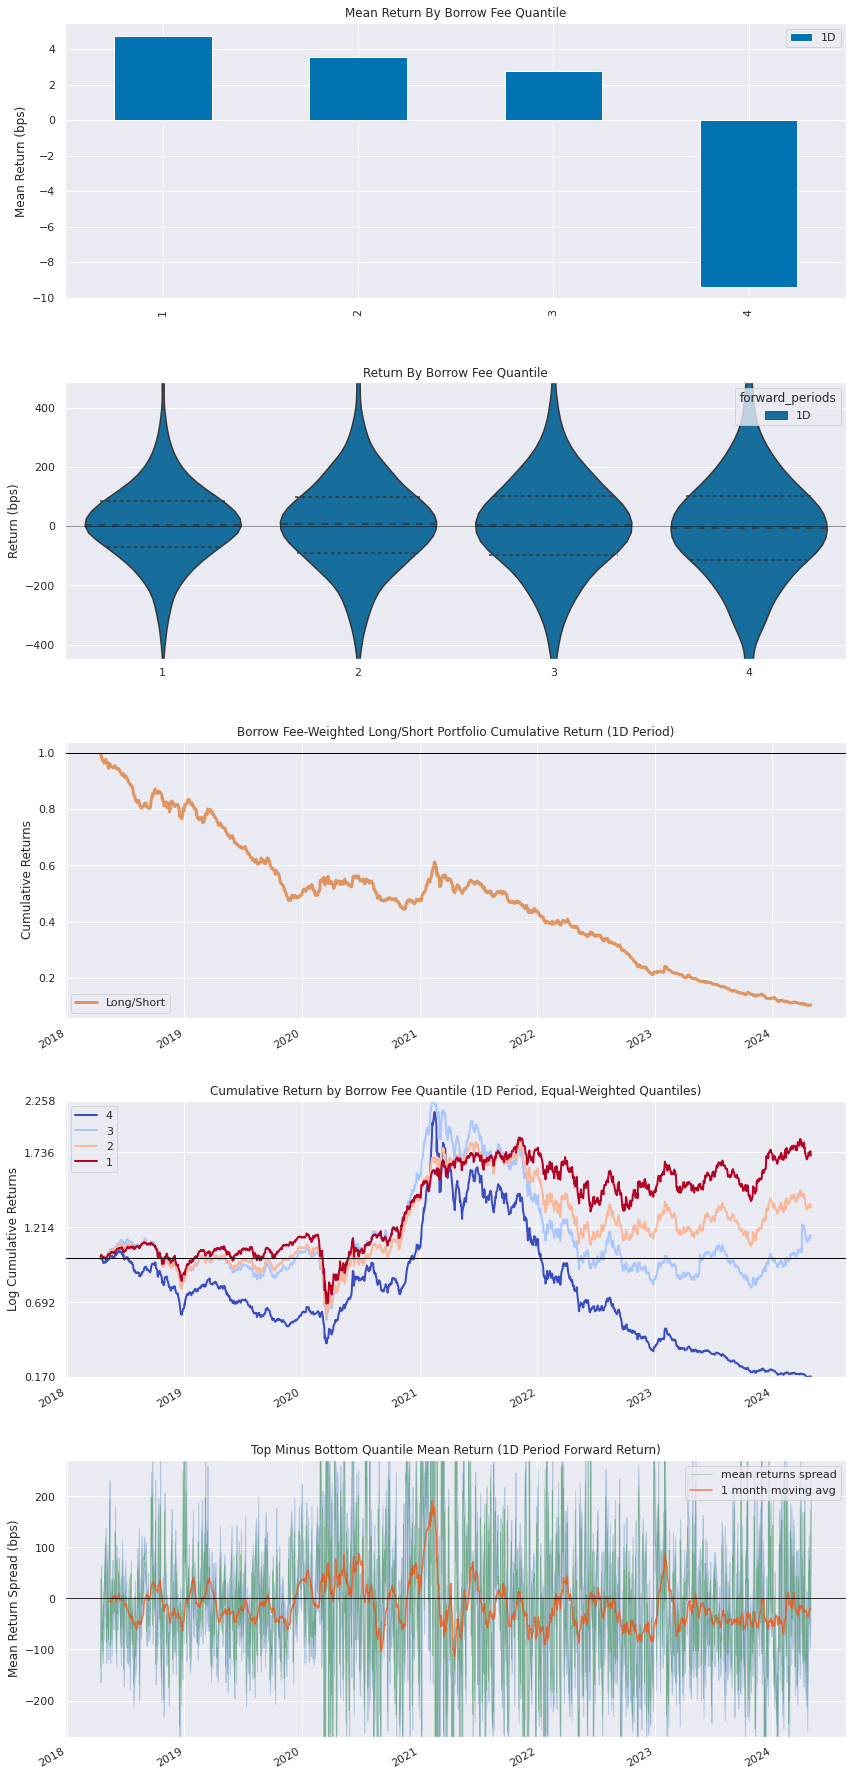

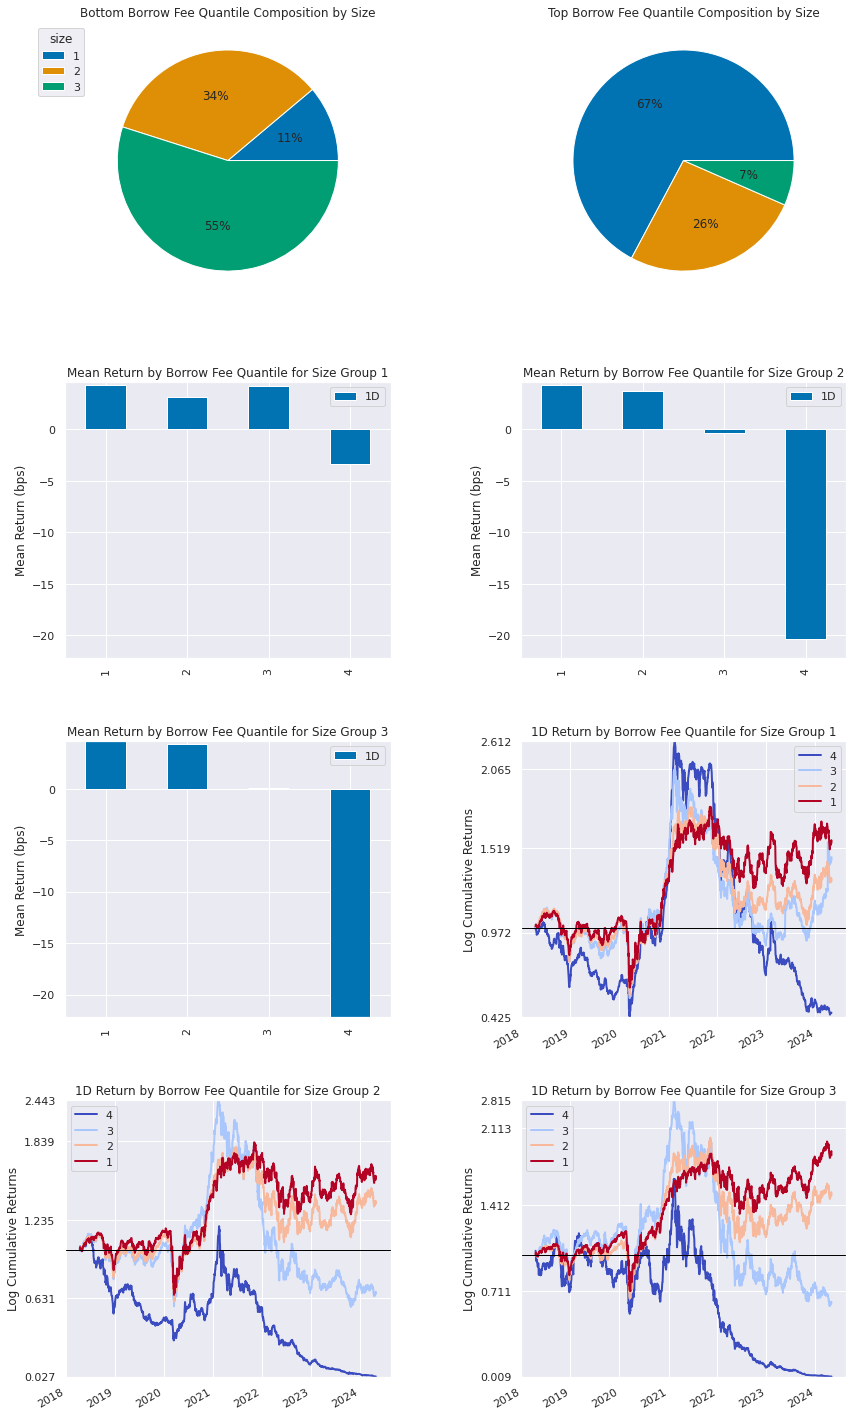

,1D
IC Mean,-0.042
IC Std.,0.106
Risk-Adjusted IC,-0.397
t-stat(IC),-15.469
p-value(IC),0.000
IC Skew,-0.036
IC Kurtosis,0.783


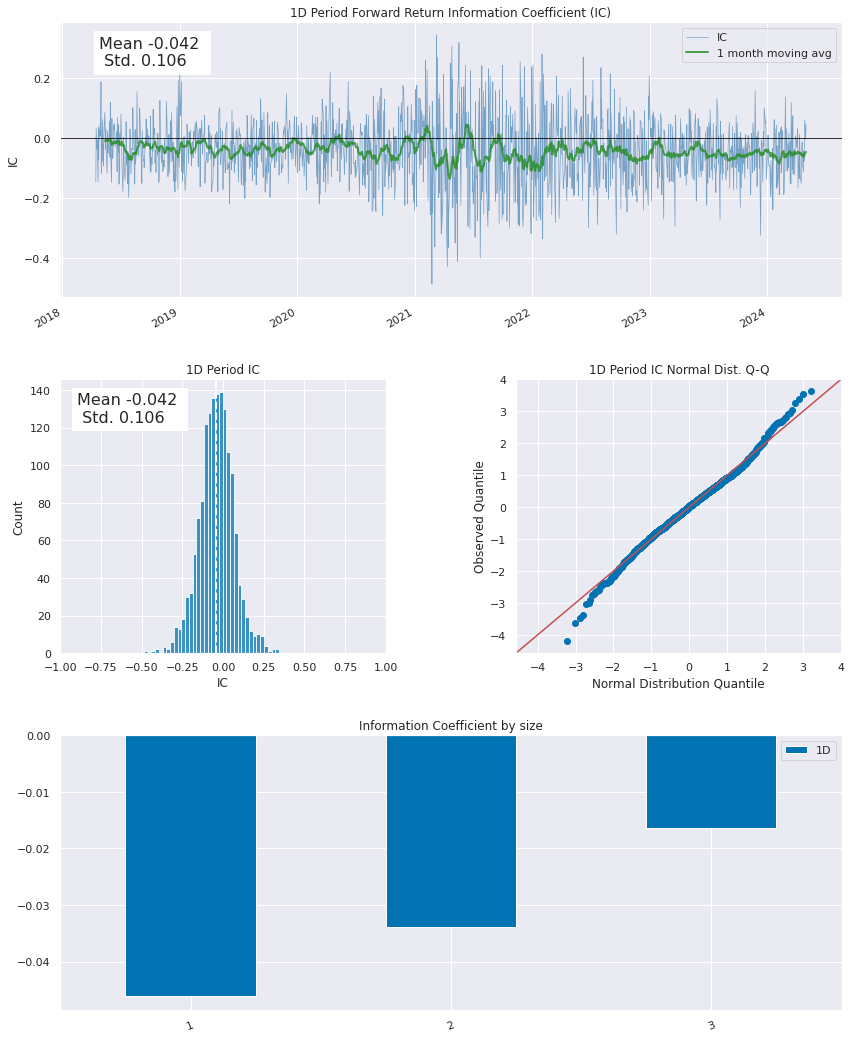

,1D
Quantile 1 Mean Turnover,0.090
Quantile 2 Mean Turnover,0.219
Quantile 3 Mean Turnover,0.126
Quantile 4 Mean Turnover,0.034


,1D
Mean Factor Rank Autocorrelation,0.903


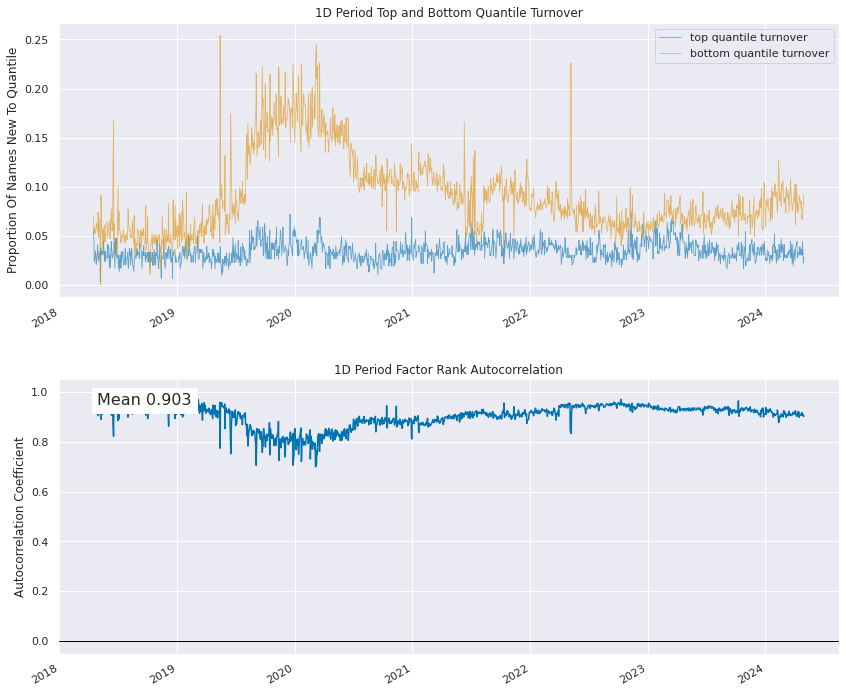

1D  ...  size
date       asset                                    ...      
2018-04-16 Equity(FIBBG000C2V3D6 [A])     0.014284  ...     3
           Equity(FIBBG00B3T3HD3 [AA])    0.001274  ...     3
           Equity(FIBBG006T1NZ18 [AAC])   0.026902  ...     1
           Equity(FIBBG005P7Q881 [AAL])   0.011554  ...     3
           Equity(FIBBG000D9V7T4 [PRG])   0.021608  ...     3
...                                            ...  ...   ...
2024-04-30 Equity(FIBBG01K4M3BZ5 [YYGH]) -0.095785  ...     1
           Equity(FIBBG01K02D4G9 [NCI])  -0.124138  ...     1
           Equity(FIBBG01M86F4Y6 [LOAR])  0.049549  ...     2
           Equity(FIBBG001VHP597 [MRX])  -0.004137  ...     1
           Equity(FIBBG008D32605 [RBRK]) -0.085143  ...     2

[5211430 rows x 4 columns]

In [3]:
import alphalens as al

al.from_pipeline(
    pipeline,
    start_date="2018-04-16", # this is the start date of the borrow fees data
    end_date="2024-04-30",
    factor="borrow_fee",
    groupby="size",
    quantiles=[0, 0.5, 0.75, 0.9, 1], # split at 50th, 75th, and 90th percentile
    relative_returns=False, # Alphalens shows relative and absolute returns by default, let's ignore relative
    segment="Y"
)

## Tear sheet commentary

### Factor Distribution table

* `mean`: The mean borrow fee is below 1% in quantiles 1 and 2 (covering 75% of stocks) and is below 4% in quantile 3. But in quantile 4, the mean borrow fee jumps to over 60%.

### Returns Analysis

* `Mean Relative Return By Borrow Fee Quantile`: Across all quantiles, forward returns decrease as borrow fees increase. Forward returns dramatically decline in quantile 4 (the most expensive 10% of stocks to borrow). 
* `Borrow Fee-Weighted Long/Short Portfolio Cumulative Return`: this plot reflects a long/short portfolio where we long all stocks with high borrow fees and short all stocks with low borrow fees, with each position's weight being proportional to its borrow fee. By convention, Alphalens always longs the higher quantiles and shorts the lower quantiles. In this case, that results in strongly negative performance. We can mentally invert the plot and see that shorting hard-to-borrow stocks and buying easy-to-borrow ones would be profitable (before transaction costs). 
* `Actual Cumulative Return by Quantile`: this plot shows the cumulative performance of 4 portfolios formed from the 4 quantiles, with positions being equal-weighted within each portfolio. Stocks with the highest borrow fees (quantile 4) spiked higher during the pandemic, but otherwise have had a strong tendency to decline.
* `Bottom/Top Borrow Fee Quantile Composition by size`: these pie charts are included because we specified a `groupby` column. The column was called "size" and reflected a division of the universe into 4 quantiles by market cap. Here we only see 3 quantiles because we excluded the smallest size quantile (size quantile 0, containing microcaps). The pie charts reveal that largecap stocks (size quantile 3) are over-represented in the bottom borrow fee quantile, while smallcap stocks (size quantile 1) are over-represented in the top borrow fee quantile. In other words, largecap stocks tend to be cheaper to borrow than smallcap stocks.
* `Mean Return by Borrow Fee Quantile for Size Group N` and `1D Return by Borrow Fee Quantile for Size Group N`: these bar charts and cumulative return plots show that high borrow fees negatively predict future returns across all 3 size quantiles included in the analysis.    

***

## *Next Up*

Part 4: [Moonshot Strategy Code](Part4-Moonshot-Strategy-Code.ipynb)